In [1]:
import pinocchio as pin
import numpy as np
from pinocchio.visualize import MeshcatVisualizer
import hppfcl
from tqdm import trange
import matplotlib.pyplot as plt
import time
import crocoddyl as cdl
import example_robot_data as erd
import imageio
import os
from pathlib import Path
from tqdm import tqdm
from qcqp import BoxQPFn2
import torch

In [2]:
from utils.utils import make_video, RK4Update, EulerUpdate, aba_with_friction, aba_with_friction5, aba_with_friction4, RK4Update_with_friction
from utils.utils import smooth_friction_action_model

In [3]:
path_curr = Path().cwd()
os.makedirs(path_curr/'videos', exist_ok=True)

## Simulating pendulum

In [4]:
robot = erd.load("double_pendulum")
model = robot.model

In [5]:
end_placement = pin.SE3.Identity()
end_placement.translation = np.array([0.,0.,0.2])
end_frame = pin.Frame("end_pendulum_frame", model.getJointId("joint2"), 0, end_placement, pin.FrameType(3))
model.addFrame(end_frame)
data = model.createData()

In [6]:
geom_model = robot.collision_model
geom_data = robot.collision_data

In [7]:
q_init = np.zeros(model.nq) #+ 1.*np.pi
q_init[0] +=  1.*np.pi + 0.*np.pi
q_init[1] +=  0.*np.pi
v_init = np.zeros(model.nv)
x0 = np.concatenate([q_init, v_init])
a_init = np.zeros(model.nv)
pin.forwardKinematics(model, data, q_init)
pin.updateFramePlacements(model, data)
pin.updateGeometryPlacements(model, data, geom_model, geom_data)

In [8]:
name = "double_pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)
viz.viewer.jupyter_cell()


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [9]:
dt = 0.001
T = 10000
q,v,a = q_init, v_init, a_init
u = np.zeros((T,model.nv))
positions = []
for i in range(T):
    #q,v = RK4Update_with_friction(model,data, q, v, u[i] , dt, 0.1*np.ones(model.nv))
    v, _ = aba_with_friction4(model,data,q,v,u[i],1.*np.ones(model.nv),dt)
    q = pin.integrate(model,q, v*dt)
    #print("v",v)
    pin.forwardKinematics(model, data, q)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data)
    positions += [q.copy()]

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
/tmp/ipykernel_21414/1138728202.py:64: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


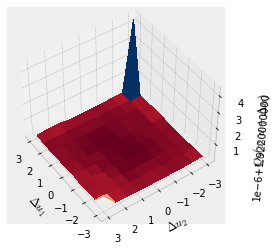

In [42]:
def compute_cost(model,data,q,v,u,final):
    wef_cur, wef_final = 0.,10.
    wur_cur, wur_final = 1e-8,1e-8
    wxr_cur, wxr_final = 1e-10, 1e-10
    cost_tot = 0.
    ef_trans = data.oMf[-1].translation
    if final:
        cost_tot += wef_final*.5*np.sum(np.square(ef_trans-np.array([0.0290872, 0., 0.355])))
        cost_tot += wur_final*.5*np.sum(np.square(u))
        cost_tot += wxr_final*.5*np.sum(np.square(v))
        
    else:
        cost_tot += wef_cur*.5*np.sum(np.square(ef_trans-np.array([0.0290872, 0., 0.355])))
        cost_tot += wur_cur*.5*np.sum(np.square(u))
        cost_tot += wxr_cur*.5*np.sum(np.square(v))
    return cost_tot 


def Q_0(x,u,us,model,data,dt):
    Qvalue = 0.
    q, v = x[:model.nq], x[model.nq:]
    a, _ = aba_with_friction5(model,data,q,v,u,cf,dt)
    v = v + dt*a
    q = pin.integrate(model,q,v*dt)
    pin.forwardKinematics(model, data, q)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data)
    Qvalue += compute_cost(model,data,q,v,u,False)
    for t in range(len(us)-1):
        a, _ = aba_with_friction5(model,data,q,v,us[t],cf,dt)
        v = v + dt*a
        q = pin.integrate(model,q,v*dt)
        pin.forwardKinematics(model, data, q)
        pin.updateGeometryPlacements(model, data, geom_model, geom_data)
        Qvalue += compute_cost(model,data,q,v,us[t],False)
    a, _ = aba_with_friction5(model,data,q,v,us[-1],cf,dt)
    v = v + dt*a
    q = pin.integrate(model,q,v*dt)
    pin.forwardKinematics(model, data, q)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data)
    Qvalue += compute_cost(model,data,q,v,us[-1],True)
    return Qvalue

import matplotlib.ticker as tick 
from matplotlib import cm
import matplotlib.pyplot as plt 
plt.style.use('bmh')

def plot_Q_function(x,u,us,cf,dt,model,data,delta_u,save=False):
    b = delta_u
    d = delta_u

    B, D = np.meshgrid(b, d)
    Qvalues = np.zeros((delta_u.shape[0],delta_u.shape[0]))
    for i in trange(delta_u.shape[0]):
        for j in range(delta_u.shape[0]):
            delta = np.zeros(u.shape)
            delta[0] = delta_u[i]
            delta[1] = delta_u[j]
            Qvalue = Q_0(x,u+delta,us,model,data,dt)
            Qvalues[i,j] = Qvalue
    nu = Qvalues

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(elev=45., azim=145)
    surf = ax.plot_surface(B, D, nu, rstride=1, cstride=1, cmap=cm.RdBu,linewidth=0, antialiased=False)
    #ax.zaxis.set_major_locator(LinearLocator(10))
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.xlabel(r'$\Delta u_1$')
    plt.ylabel(r'$\Delta u_2$')
    ax.set_zlabel(r'$Q_0(x,u+\Delta u)$')
    if save:
        path_curr = Path.cwd()
        save_path = path_curr/'logs'/'double_pendulum'
        os.makedirs(save_path,exist_ok=True)
        plt.savefig(save_path/"Q_0.pdf")
    plt.show()
    plt.close()

Ngrid = 10
delta_u = np.linspace(-3.,3.,Ngrid)
T=1500
dt = 1e-3
cf = 0.05
plot_Q_function(np.array([np.pi,0.,0.,0.]),np.zeros(2),np.zeros((T-1,2)),cf,dt,model,data,delta_u,save=True)


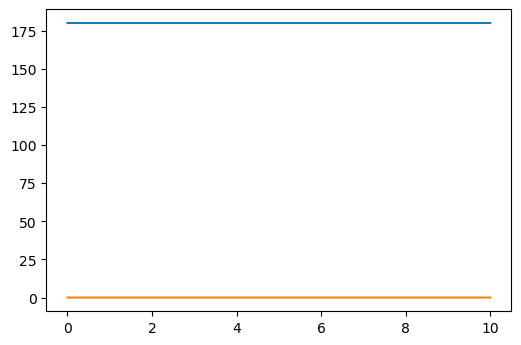

In [20]:
plt.figure(dpi=100)
plt.plot([i*dt for i in range(len(positions))], np.array(positions)*180./np.pi)
plt.show()

In [ ]:
plt.figure(dpi=100)
plt.plot([i*dt for i in range(len(positions))], np.array(positions)*180./np.pi)
plt.show()

In [10]:
time.sleep(2.)
viz.play(np.mod(np.array(positions).T, 2*np.pi), dt=0.001)

In [ ]:
path_curr = Path().cwd()
fps = 20.
dt_fps = 1./fps
red_coeff = int(dt_fps/dt)
positions_to_record = [np.array(positions)[i*red_coeff] for i in range(int(len(positions)/red_coeff))]
os.makedirs(path_curr/'videos'/'double_pendulum_with_frictions', exist_ok=True)
make_video(viz, np.array(positions_to_record), path_curr/'videos'/'double_pendulum_with_frictions'/'simulation.mp4', fps)

## Controlling with DDP

In [11]:
# Create the cost functions
target = np.array([0.0290872, 0., 0.355])
Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum_frame"), target)

state = cdl.StateMultibody(model)
goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
xRegCost_cur = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(np.array([1e-10,1e-10,1e-10,1e-10])), np.zeros(4))
xRegCost_final = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(1e-3*np.array([1e-7,1e-7,1e-7,1e-7])), np.zeros(4))
uRegCost_cur = cdl.CostModelControl(state, cdl.ActivationModelWeightedQuad(np.array([1e-4,1e-4])), np.zeros(2))
uRegCost_final = cdl.CostModelControl(state, cdl.ActivationModelWeightedQuad(1e-3*np.array([1e-1,1e-1])), np.zeros(2))
xCost_cur = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(0.*np.array([1e-6,1e-6,0.,0.])), np.zeros(4))
xCost_final = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(0.*np.array([1e-0,1e-0,0.,0.])), np.zeros(4))

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)
DT = 1e-3

# Then let's add the running and terminal cost functions
runningCostModel.addCost("pendulumPose", goalTrackingCost, 0.)#1e-3)
runningCostModel.addCost("stateReg", xRegCost_cur, 1e0/DT)
runningCostModel.addCost("ctrlReg", uRegCost_cur, 1e-0/DT)
runningCostModel.addCost("stateCost", xCost_cur, 1e-0/DT)
terminalCostModel.addCost("pendulumPose", goalTrackingCost, 1e-0)
terminalCostModel.addCost("stateReg", xRegCost_final, 1e0)
terminalCostModel.addCost("ctrlReg", uRegCost_final, 1e-0)
terminalCostModel.addCost("stateCost", xCost_final, 1e-0)

# Running and terminal action models
actuationModel = cdl.ActuationModelFull(state)
runningModel = cdl.IntegratedActionModelEuler(
    cdl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, runningCostModel), DT)
terminalModel = cdl.IntegratedActionModelEuler(
    cdl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, terminalCostModel), 0.)
#runningModel, terminalModel = smooth_friction_action_model(state,[0,1],Mref,)

In [12]:
# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 1500
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [13]:
# Creating the DDP solver for this OC problem, defining a logger
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [14]:
# Solving it with the DDP algorithm
init_us = [np.zeros(model.nv)+0.01]*T
init_xs = problem.rollout(init_us)
ddp.solve(init_xs, init_us, 100)

True

In [15]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [16]:
viz.display(q_init)
time.sleep(3.)
xs = np.stack(ddp.xs)
viz.play(xs[:,:model.nq].T,DT)

In [ ]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

## Controlling the pendulum with dry frictions 

In [28]:
class DifferentialFrictionFwdDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel, cf, dt):
        cdl.DifferentialActionModelAbstract.__init__(self, state, state.nv, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.costWeights = 0
        self.cf = cf
        self.dt = dt

    def calc(self, data, x, u=None):
        if u is None:
            u = self.unone
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:], _ = aba_with_friction5(self.state.pinocchio, data.pinocchio, q, v, u, self.cf, self.dt)
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, u)
        data.cost = data.costs.cost

    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        self.calc(data, x, u)
        # Computing the dynamics derivatives
        pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, u)
        Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
        Fui = data.pinocchio.Minv
        for i in range(self.state.nv):
            if np.abs(v)[i]<1e-3:
                if data.xout[i] == 0.:
                    #Fxi[i][:] = 0
                    Fui[i][:] = 0
        data.Fx[:] = Fxi
        data.Fu[:] = Fui
        self.costs.calcDiff(data.costs, x, u)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data
    

In [29]:
# Create the cost functions
#target = np.array([0.0290872, 0., 0.135])
#Mref = cdl.FrameTranslation(model.getFrameId("link2"), target)
target = np.array([0.0290872, 0., 0.355])
Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum_frame"), target)
state = cdl.StateMultibody(model)
goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
xRegCost_cur = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(np.array([1e-10,1e-10,1e-10,1e-10])), np.zeros(4))
xRegCost_final = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(1e-3*np.array([1e-7,1e-7,1e-7,1e-7])), np.zeros(4))
uRegCost_cur = cdl.CostModelControl(state, cdl.ActivationModelWeightedQuad(np.array([1e-4,1e-4])), np.zeros(2))
uRegCost_final = cdl.CostModelControl(state, cdl.ActivationModelWeightedQuad(1e-3*np.array([1e-1,1e-1])), np.zeros(2))
xCost_cur = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(0.*np.array([1e-6,1e-6,0.,0.])), np.zeros(4))
xCost_final = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(0.*np.array([1e-0,1e-0,0.,0.])), np.zeros(4))

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)
DT = 1e-3

# Then let's add the running and terminal cost functions
runningCostModel.addCost("pendulumPose", goalTrackingCost, 0.)#1e-3)
runningCostModel.addCost("stateReg", xRegCost_cur, 1e0/DT)
runningCostModel.addCost("ctrlReg", uRegCost_cur, 1e-0/DT)
runningCostModel.addCost("stateCost", xCost_cur, 1e-0/DT)
terminalCostModel.addCost("pendulumPose", goalTrackingCost, 1.)
terminalCostModel.addCost("stateReg", xRegCost_final, 1e0)
terminalCostModel.addCost("ctrlReg", uRegCost_final, 1e-0)
terminalCostModel.addCost("stateCost", xCost_final, 1e-0)

# Running and terminal action models
cf = 0.
pendulumDAM = DifferentialFrictionFwdDynamics(state, runningCostModel, cf, DT)
pendulumDAM.createData()
terminalPendulumDAM = DifferentialFrictionFwdDynamics(state, terminalCostModel, cf, DT)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelEuler(
    pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelEuler(
    terminalPendulumDAM, 0.)

Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated CostModelFrameTranslation: Use ResidualModelFrameTranslation with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual
Deprecated CostModelControl: Use ResidualModelControl with CostModelResidual
Deprecated CostModelControl: Use ResidualModelControl with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual


In [30]:
# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 1500
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [31]:
# Creating the DDP solver for this OC problem, defining a loggeras no attribute 'p
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [33]:
# Solving it with the DDP algorithm
init_us = [np.zeros_like(a_init)+0.01]*T
init_xs = problem.rollout(init_us)
ddp.solve(init_xs,init_us,100)

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  1.43507e-01  1.85514e-06  1.84659e-02  1.00000e-09  1.00000e-09   0.5000     1
   1  1.00981e-01  2.89847e-05  2.85331e-01  1.00000e-09  1.00000e-09   0.5000     1
   2  9.01410e-02  1.98596e-05  1.92117e-01  1.00000e-09  1.00000e-09   0.2500     1
   3  8.13027e-02  1.60507e-05  1.58738e-01  1.00000e-09  1.00000e-09   0.0625     1
   4  7.16377e-02  1.26332e-05  1.23595e-01  1.00000e-09  1.00000e-09   0.5000     1
   5  4.24273e-02  1.47400e-05  1.42527e-01  1.00000e-09  1.00000e-09   1.0000     1
   6  4.02870e-02  8.56381e-06  8.31082e-02  1.00000e-09  1.00000e-09   0.2500     1
   7  1.54019e-02  8.22526e-06  8.00357e-02  1.00000e-09  1.00000e-09   1.0000     1
   8  8.79844e-03  3.01307e-06  2.95611e-02  1.00000e-09  1.00000e-09   1.0000     1
   9  2.68753e-03  1.70491e-06  1.66484e-02  1.00000e-09  1.00000e-09   0.5000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  1.71426e

True

  43  5.26296e-04  9.79923e-10  9.70241e-06  1.00000e-09  1.00000e-09   1.0000     1


In [19]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [20]:
xs = np.stack(ddp.xs)
viz.play(xs[:,:model.nq].T,DT)

In [ ]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

## DDP with smoothed dynamics

In [ ]:
class DifferentialSmoothFwdDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel, nbSamples, noiseIntensity):
        cdl.DifferentialActionModelAbstract.__init__(self, state, state.nv, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.nbSamples = nbSamples
        self.noiseIntensity = noiseIntensity
        self.costWeights = 0

    def calc(self, data, x, u=None, uNoise = None):
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        if u is None:
            u = self.unone
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:] = 0
        for ui in uNoise:
            data.xout[:] += pin.aba(self.state.pinocchio, data.pinocchio, q, v, u+ ui)/self.nbSamples
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, u)
        data.cost = data.costs.cost

    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        self.calc(data, x, u, uNoise)
        # Computing the dynamics derivatives
        data.Fx[:] = 0
        data.Fu[:] = 0
        for ui in uNoise:
            pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, u + ui)
            data.Fx[:] += np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])/self.nbSamples
            data.Fu[:] += data.pinocchio.Minv/self.nbSamples
        # Computing the cost derivatives
        self.costs.calcDiff(data.costs, x, u)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data
    

In [ ]:
# Create the cost functions
#target = np.array([0.0290872, 0., 0.135])
#Mref = cdl.FrameTranslation(model.getFrameId("link2"), target)
target = np.array([0.0290872, 0., 0.335])
Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum_frame"), target)
state = cdl.StateMultibody(model)
goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
xRegCost = cdl.CostModelState(state)
uRegCost = cdl.CostModelControl(state)

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("pendulumPose", goalTrackingCost, 1e-7)
runningCostModel.addCost("stateReg", xRegCost, 1e-7)
runningCostModel.addCost("ctrlReg", uRegCost, 1e-1)
terminalCostModel.addCost("pendulumPose", goalTrackingCost, 1e-0)
terminalCostModel.addCost("stateReg", xRegCost, 1e-7)
terminalCostModel.addCost("ctrlReg", uRegCost, 1e-7)

# Running and terminal action models
DT = 1e-3
noiseIntensity = 1e-1
nbSamples = 8
#actuationModel = cdl.ActuationModelFull(state)
pendulumDAM = DifferentialSmoothFwdDynamics(state, runningCostModel, nbSamples, noiseIntensity)
pendulumDAM.createData()
terminalPendulumDAM = DifferentialSmoothFwdDynamics(state, terminalCostModel, nbSamples, noiseIntensity)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelEuler(
    pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelEuler(
    terminalPendulumDAM, 1.)

In [ ]:
# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 1500
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [ ]:
# Creating the DDP solver for this OC problem, defining a loggeras no attribute 'p
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()
ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [ ]:
# Solving it with the DDP algorithm
init_us = [np.zeros_like(a_init)]*T
init_xs = problem.rollout(init_us)
ddp.solve(init_xs, init_us)

In [ ]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.viewer.jupyter_cell()

In [ ]:
xs = np.stack(ddp.xs)
viz.play(xs[:,:model.nq].T,DT)

In [ ]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

## DDP on smooth dynamics with friction

In [ ]:
class DifferentialSmoothFrictionDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel, nbSamples, noiseIntensity, cf):
        cdl.DifferentialActionModelAbstract.__init__(self, state, state.nv, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.nbSamples = nbSamples
        self.noiseIntensity = noiseIntensity
        self.costWeights = 0
        self.cf = cf

    def calc(self, data, x, u=None, uNoise = None):
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        if u is None:
            u = self.unone
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:] = 0
        for ui in uNoise:
            data.xout[:] += aba_with_friction(self.state.pinocchio, data.pinocchio, q, v, u+ ui, self.cf)/self.nbSamples
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, u)
        data.cost = data.costs.cost
        


    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        self.calc(data, x, u, uNoise)
        # Computing the dynamics derivatives
        data.Fx[:] = 0
        data.Fu[:] = 0
        for ui in uNoise:
            pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, u+ui)
            Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
            Fui = data.pinocchio.Minv
            for i in range(self.state.nv):
                if np.abs(v)[i]<1e-3:
                    if data.xout[i] != 0:
                        continue
                    else:
                        Fxi[i][:] = 0
                        Fui[i][:] = 0
                else:
                    continue
            data.Fx[:] += Fxi/self.nbSamples
            data.Fu[:] += Fui/self.nbSamples
        # Computing the cost derivatives
        self.costs.calcDiff(data.costs, x, u)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data

In [ ]:
# Create the cost functions
#target = np.array([0.0290872, 0., 0.135])
#Mref = cdl.FrameTranslation(model.getFrameId("link2"), target)
target = np.array([0.0290872, 0., 0.435])
Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum_frame"), target)
state = cdl.StateMultibody(model)
goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
xRegCost = cdl.CostModelState(state)
uRegCost = cdl.CostModelControl(state)

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("pendulumPose", goalTrackingCost, 1e-7)
runningCostModel.addCost("stateReg", xRegCost, 1e-7)
runningCostModel.addCost("ctrlReg", uRegCost, 1e-1)
terminalCostModel.addCost("pendulumPose", goalTrackingCost, 1.)
terminalCostModel.addCost("stateReg", xRegCost, 1e-7)
terminalCostModel.addCost("ctrlReg", uRegCost, 1e-7)

# Running and terminal action models
DT = 1e-3
noiseIntensity = 3e-1
nbSamples = 4
#actuationModel = cdl.ActuationModelFull(state)
pendulumDAM = DifferentialSmoothFrictionDynamics(state, runningCostModel,nbSamples, noiseIntensity, 0.01)
#pendulumDAM = cdl.DifferentialActionModelNumDiff(pendulumDAM,False)
pendulumDAM.createData()
terminalPendulumDAM = DifferentialSmoothFrictionDynamics(state, terminalCostModel,nbSamples, noiseIntensity, 0.01)
#terminalPendulumDAM = cdl.DifferentialActionModelNumDiff(terminalPendulumDAM,False)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelEuler(
    pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelEuler(
    terminalPendulumDAM, 0.)

In [ ]:
# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 1500
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)


In [ ]:
# Creating the DDP solver for this OC problem, defining a loggeras no attribute 'p
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [ ]:
# Solving it with the DDP algorithm
init_us = [np.zeros_like(a_init)]*T
init_xs = problem.rollout(init_us)
ddp.solve(init_xs, init_us, 20)

In [ ]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.viewer.jupyter_cell()

In [ ]:
xs = np.stack(ddp.xs)
viz.play(xs[:,:model.nq].T,DT)

In [ ]:
path_curr = Path().cwd()
positions = xs[:,:model.nq]
fps = 100.
dt_fps = 1./fps
red_coeff = int(dt_fps/DT)
positions_to_record = [np.array(positions)[i*red_coeff] for i in range(int(len(positions)/red_coeff))]
os.makedirs(path_curr/'videos'/'double_pendulum_with_frictions', exist_ok=True)
make_video(viz, np.array(positions_to_record), path_curr/'videos'/'double_pendulum_with_frictions'/'RSDDP.mp4', fps)

In [ ]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

# Acrobot with friction

In [ ]:
class AcrobotSmoothFrictionDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel, nbSamples, noiseIntensity, cf):
        cdl.DifferentialActionModelAbstract.__init__(self, state, 1, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.nbSamples = nbSamples
        self.noiseIntensity = noiseIntensity
        self.costWeights = 0
        self.cf = cf

    def calc(self, data, x, u=None, uNoise = None):
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        if u is None:
            u = self.unone
        q, v = x[:self.state.nq], x[-self.state.nv:]
        action = np.zeros(state.nv)
        action[1] = u
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:] = 0
        for ui in uNoise:
            actioni = np.zeros(state.nv)
            actioni[1] = u +ui
            data.xout[:] += aba_with_friction(self.state.pinocchio, data.pinocchio, q, v, actioni, self.cf)/self.nbSamples
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, action)
        data.cost = data.costs.cost
        


    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        action = np.zeros(state.nv)
        action[1] = u
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        self.calc(data, x, u, uNoise)
        # Computing the dynamics derivatives
        data.Fx[:] = 0
        data.Fu[:] = 0
        for ui in uNoise:
            actioni = np.zeros(state.nv)
            actioni[1] = u +ui
            pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, actioni)
            Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
            Fui = data.pinocchio.Minv
            for i in range(self.state.nv):
                if np.abs(v)[i]<1e-3:
                    if data.xout[i] != 0:
                        continue
                    else:
                        Fxi[i][:] = 0
                        Fui[i][:] = 0
                else:
                    continue
            data.Fx[:] += Fxi/self.nbSamples
            data.Fu[:] += Fui[:,0]/self.nbSamples
        #print(data.Fx, data.Fu)
        # Computing the cost derivatives
        self.costs.calcDiff(data.costs, x, action)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data

In [ ]:
# Create the cost functions
#target = np.array([0.0290872, 0., 0.135])
#Mref = cdl.FrameTranslation(model.getFrameId("link2"), target)
target = np.array([0.0290872, 0., 0.335])
Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum_frame"), target)
state = cdl.StateMultibody(model)
goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
w_stateCost = np.array([0.,0.,1.,1.])
xRegCost = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(w_stateCost), np.zeros(4))
uRegCost = cdl.CostModelControl(state)

DT = 1e-3

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("pendulumPose", goalTrackingCost, 1e-8/DT)
runningCostModel.addCost("stateReg", xRegCost, 1e-5/DT)
runningCostModel.addCost("ctrlReg", uRegCost, 1e-10/DT)
terminalCostModel.addCost("pendulumPose", goalTrackingCost, 1.)
terminalCostModel.addCost("stateReg", xRegCost, 1e-5)
terminalCostModel.addCost("ctrlReg", uRegCost, 1e-10)

# Running and terminal action models
noiseIntensity = 5e-1
nbSamples = 4
#actuationModel = cdl.ActuationModelFull(state)
pendulumDAM = AcrobotSmoothFrictionDynamics(state, runningCostModel,nbSamples, noiseIntensity, 0.01)
#pendulumDAM = cdl.DifferentialActionModelNumDiff(pendulumDAM,False)
pendulumDAM.createData()
terminalPendulumDAM = AcrobotSmoothFrictionDynamics(state, terminalCostModel,nbSamples, noiseIntensity, 0.01)
#terminalPendulumDAM = cdl.DifferentialActionModelNumDiff(terminalPendulumDAM,False)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelRK4(
    pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelRK4(
    terminalPendulumDAM, 0.)

In [ ]:
T = 1500
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [ ]:
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [ ]:
init_us = [np.zeros(1)]*T
init_xs = problem.rollout(init_us)
ddp.solve(init_xs, init_us, 40)

In [ ]:
viz.viewer.jupyter_cell()

In [ ]:
xs = np.stack(ddp.xs)
viz.play(xs[:,:model.nq].T,DT)

In [ ]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)